<a href="https://colab.research.google.com/github/prodriguezl1998/datasharing/blob/master/patricia_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><b>
Arboles de Decision  <br/>
Patricia Rodriguez <br/></b></center> <br/>






Evaluaremos incialmente la aplicacion de los arboles de clasificación 

**1) Iniciaremos con la formulación de un problema. </br>**

Los modelos de clasificacion se utilizan para predecir 
el valor de una variable mediante la clasificación de la información en función de otras variables (tipo, pertenencia a un grupo…). 


> En nuestro caso, queremos pronosticar qué clientes de determinado banco anularán su cuenta bancaria tomando en cuenta sus puntos de credito, su sexo,edad, saldo, numero de productos con el banco, si es poseedor de una tarjeta de crédito, si es un miembro activo del banco y finalmente, su salario estimado. Los valores a predecir son predefinidos, es decir, los resultados están definidos en un conjunto de posibles valores


In [ ]:
# Importamos los paquetes necesarios
import os 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
# Cambiar numeros a float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
# Aumentar el tamaño de los plots sns
sns.set(rc={'figure.figsize':(8,6)})
# Datetime lib
from pandas import to_datetime
import itertools
import warnings
import datetime
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.tree import DecisionTreeRegressor

In [ ]:
!pip install graphviz

2) Cargamos la data en python 


> Utilizaremos 10.000 registros de un dataset proveniente de un banco.


In [ ]:
url = ('https://raw.githubusercontent.com/prodriguezl1998/Riesgo2_proyecto1/main/data_banco2.csv')
raw_data = pd.read_csv(url)
raw_data.head(4)

FILA  CLIENTE_ID  CREDITO SEXO  EDAD  TENENCIA      SALDO  NUM_PRODUCTOS  \
0     1    15634602      619    F    42         2       0.00              1   
1     2    15647311      608    F    41         1   83807.86              1   
2     3    15619304      502    F    42         8  159660.80              3   
3     4    15701354      699    F    39         1       0.00              2   

   POSEE_TC  MIEMBRO_ACTIVO  SALARIO_ESTIMADO  ANULA  
0         1               1         101348.88      1  
1         0               1         112542.58      0  
2         1               0         113931.57      1  
3         0               0          93826.63      0

2.1 ) Analisis exploratorio de variables (EDA)


> Realizamos el analisis exploratorio de variables con la finalidad de tener un insight de las relaciones entre variables.



In [ ]:
# Validar si existen NA en nuestro dataset
raw_data.isnull().sum()

FILA                0
CLIENTE_ID          0
CREDITO             0
SEXO                0
EDAD                0
TENENCIA            0
SALDO               0
NUM_PRODUCTOS       0
POSEE_TC            0
MIEMBRO_ACTIVO      0
SALARIO_ESTIMADO    0
ANULA               0
dtype: int64

In [ ]:
#Llamamos una funcion que nos describa los nombres de las columnas del dataset
raw_data.columns

Index(['FILA', 'CLIENTE_ID', 'CREDITO', 'SEXO', 'EDAD', 'TENENCIA', 'SALDO',
       'NUM_PRODUCTOS', 'POSEE_TC', 'MIEMBRO_ACTIVO', 'SALARIO_ESTIMADO',
       'ANULA'],
      dtype='object')

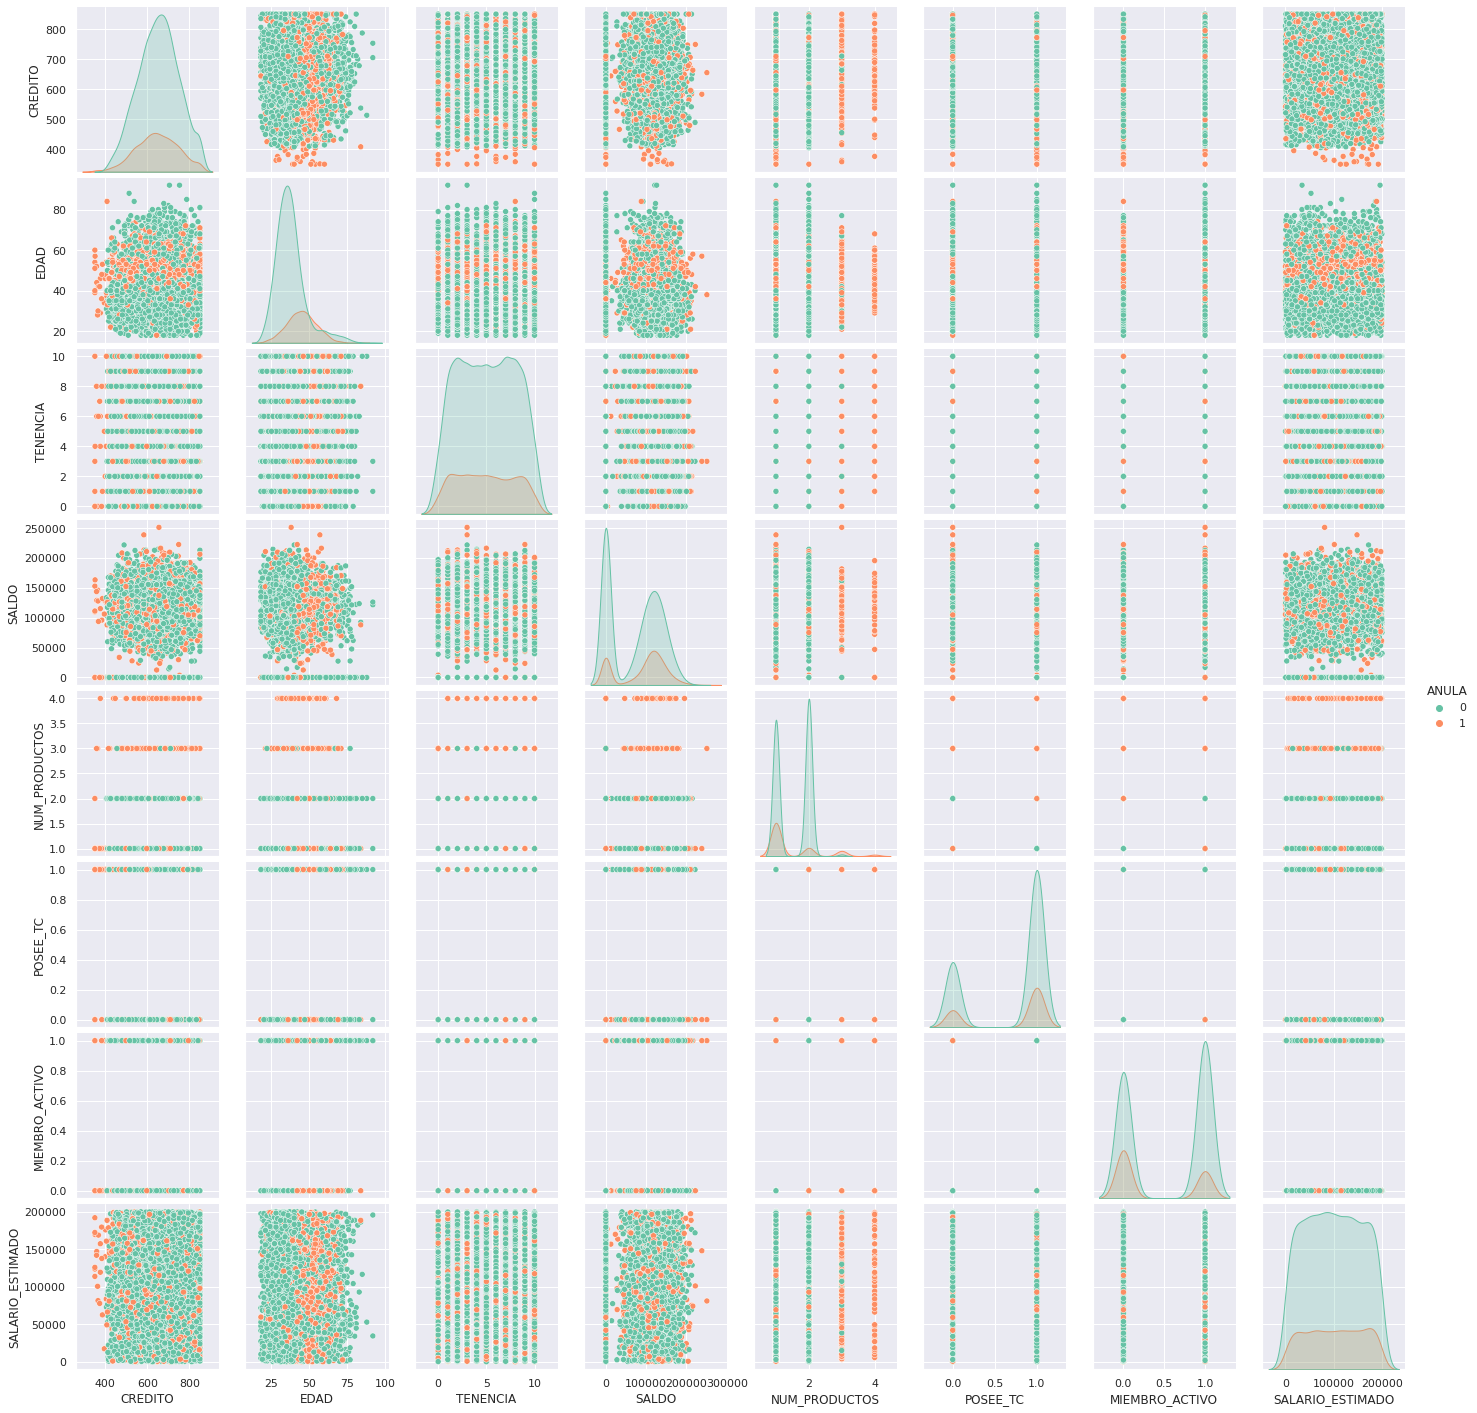

In [ ]:
# Evaluamos las variables para seleccionar las que tengan relevancia basados en las relaciones con las anulaciones, que es nuestra variable dependiente.
raw_data2 = raw_data[['CREDITO', 'SEXO', 'EDAD', 'TENENCIA', 'SALDO',
       'NUM_PRODUCTOS', 'POSEE_TC', 'MIEMBRO_ACTIVO', 'SALARIO_ESTIMADO',
       'ANULA']]

# Visualizamos
grafico1 = sns.pairplot(raw_data2, hue = 'ANULA', diag_kws={'bw': 0.2},palette = "Set2")

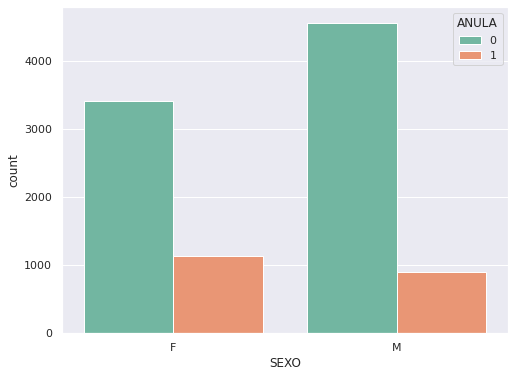

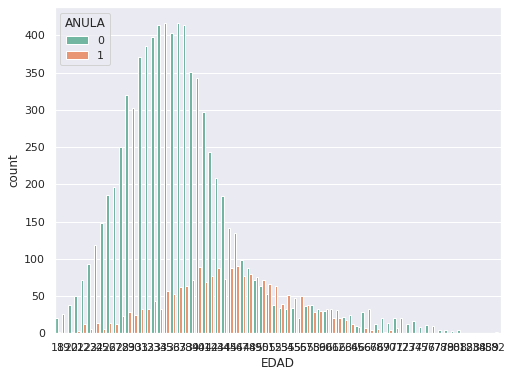

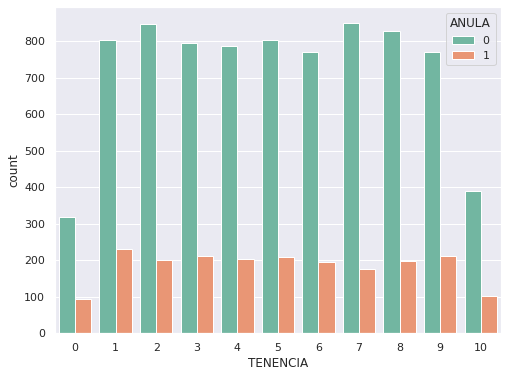

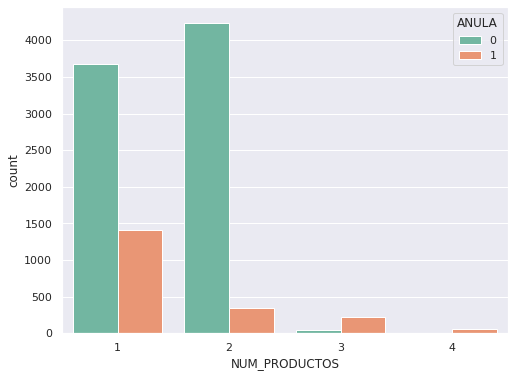

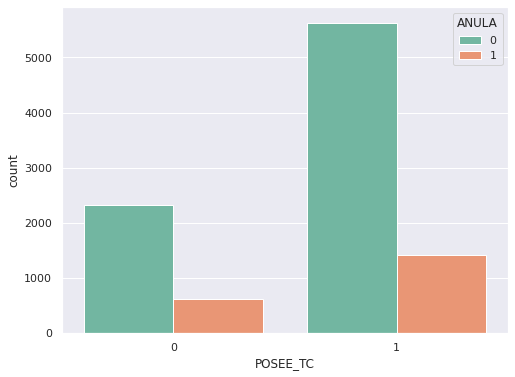

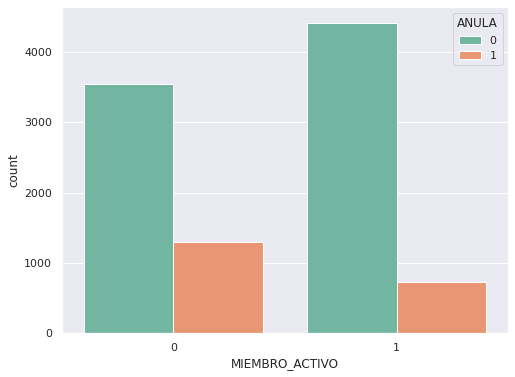

In [ ]:
# Investigar las clasificaciones respecto a y 

clasificaciones = ['SEXO', 'EDAD', 'TENENCIA', 'NUM_PRODUCTOS', 'POSEE_TC',
       'MIEMBRO_ACTIVO']


for f in clasificaciones:
    plt.figure()
    ax = sns.countplot(x=f, data=raw_data2, hue = 'ANULA', palette="Set2")

Podemos observar que las personas con 3 y 4 productos casi siempre anulan sus cuentas. 

2.2) Transformación de variables

In [ ]:
# Seguidamente, transformaremos las variables categoricas en una representacion numerica binaria (ONE HOT ENCODING)
# con la finalidad de dar valores a las categorias cualitativas (como sexo) y adicionalmente,
# que sean categorias separadas y el algoritmo no los relacione y clusterice de forma errada

new_raw_data = pd.get_dummies(raw_data2, columns = ['SEXO', 'POSEE_TC', 'MIEMBRO_ACTIVO'])
new_raw_data.head()

CREDITO  EDAD  TENENCIA      SALDO  NUM_PRODUCTOS  SALARIO_ESTIMADO  ANULA  \
0      619    42         2       0.00              1         101348.88      1   
1      608    41         1   83807.86              1         112542.58      0   
2      502    42         8  159660.80              3         113931.57      1   
3      699    39         1       0.00              2          93826.63      0   
4      850    43         2  125510.82              1          79084.10      0   

   SEXO_F  SEXO_M  POSEE_TC_0  POSEE_TC_1  MIEMBRO_ACTIVO_0  MIEMBRO_ACTIVO_1  
0       1       0           0           1                 0                 1  
1       1       0           1           0                 0                 1  
2       1       0           0           1                 1                 0  
3       1       0           1           0                 1                 0  
4       1       0           0           1                 0                 1

In [ ]:
# Para optimizar la ejecucion y precision de nuestro modelo, procederemos a escalar las columnas. 

scale_vars = ['CREDITO','SALARIO_ESTIMADO','SALDO','EDAD']
scaler = MinMaxScaler()
new_raw_data[scale_vars] = scaler.fit_transform(new_raw_data[scale_vars])
new_raw_data.head()

CREDITO      EDAD  TENENCIA     SALDO  NUM_PRODUCTOS  SALARIO_ESTIMADO  \
0    0.538  0.324324         2  0.000000              1          0.506735   
1    0.516  0.310811         1  0.334031              1          0.562709   
2    0.304  0.324324         8  0.636357              3          0.569654   
3    0.698  0.283784         1  0.000000              2          0.469120   
4    1.000  0.337838         2  0.500246              1          0.395400   

   ANULA  SEXO_F  SEXO_M  POSEE_TC_0  POSEE_TC_1  MIEMBRO_ACTIVO_0  \
0      1       1       0           0           1                 0   
1      0       1       0           1           0                 0   
2      1       1       0           0           1                 1   
3      0       1       0           1           0                 1   
4      0       1       0           0           1                 0   

   MIEMBRO_ACTIVO_1  
0                 1  
1                 1  
2                 0  
3                 0  
4                 1

3) Definimos nuestra variable a predecir (y)

In [ ]:
# Your code goes here
X = new_raw_data.drop('ANULA', axis=1).values # FILTRAR LOS ATRIBUTOS (VARIABLES INDEPENDIENTES)
y = new_raw_data['ANULA'].values # VECTOR OBJETIVO (VARIABLE DEPENDIENTE)
print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

X shape: (10000, 12)
y shape: (10000,)


> De forma que tendremos 10.000 observaciones y 12 variables para alimentar a nuestro modelo como X.



4) Separamos la data: HOLD-VALIDATION TECHNIQUE <br>


> La tecnica de Hold-validation es un método de validación cruzada, que divide aleatoriamente el conjunto de datos en datos de entrenamiento y prueba según el análisis de datos. En el caso de la validación cruzada de retención, el conjunto de datos se divide aleatoriamente en datos de entrenamiento y validación. 



> Ahora, continuamos con la validacion HOLD-OUT, para ello separamos nuestro dataset en data de entrenamiento y data de prueba. En este caso utilizaremos 90% de la data para entrenar al modelo y el 10% restante para probarlo, es decir, ese 10% constituye data que el modelo no ha visto antes, in embargo, como es data conocida para nosotros, nos permitira seleccionar el mejor modelo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)

6. EJECUTAR EL ARBOL DE DECISION

Antes de ejecutar nuestro arbol de decision es de gran importancia conocer como funciona el algortimo:

Un árbol "aprende" dividiendo el conjunto de datos en subconjuntos en función de una prueba de valor de atributo. Este proceso se repite en cada subconjunto derivado de una manera recursiva denominada ***partición recursiva***. La recursividad se completa cuando el subconjunto en un nodo tiene el mismo valor de la variable de destino, o cuando la división ya no agrega valor a las predicciones. <br/>

Inicialmente, separaremos la data hasta tener una variable dependiente y una o más variables independientes; el nodo raíz es seleccionado a partir de las variables independientes, sin embargo, la decisión final de cual variable representará la raíz del árbol depende de ciertos criterios



In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=1)

In [ ]:
dt.score(X_train,y_train)

1.0

In [ ]:
dt.score(X_test,y_test)

0.789

In [ ]:
import graphviz 
import collections
import pydotplus

dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names=new_raw_data.drop('ANULA', axis=1).columns,    
    class_names=new_raw_data['ANULA'].unique().astype(str),  
    filled=True, rounded=True,
    special_characters=True)
graph = graphviz.Source(dot_data)
graph

Observamos que la precision de nuestro modelo sobre la data de prueba es de 78% , lo cual es bueno, sin embargo, al validar la precisión sobre la data de entrenamiento, notamos un resultado del 100% lo cual es una muestra clara de un problema de sobreajuste (overfitting).El sobreajuste es un error de modelado en estadística que ocurre cuando una función está demasiado alineada con un conjunto limitado de puntos de datos. Como resultado, el modelo es útil en referencia solo a su conjunto de datos inicial y no a ningún otro conjunto de datos. Por ello realizaremos el bosque aleatorio. <br/>

<b>Prunning</b><br/>Adicionalmente, realizaremos una tecnica denominada prunning, con la finalidad de disminuir el overfitting y hacer mas entendible nuestro arbol de decision(Pues como podemos observar es bastante amplio). Pruning es una técnica de compresión de datos en aprendizaje automático y algoritmos de búsqueda que reduce el tamaño de los árboles de decisión al eliminar secciones del árbol que no son críticas y redundantes para clasificar instancias. Esto lo haremos estableciendo el parametro de max_depth como 2.

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)

In [ ]:
dt.score(X_test,y_test)

0.822

In [ ]:
dt.score(X_train,y_train)

0.8213333333333334

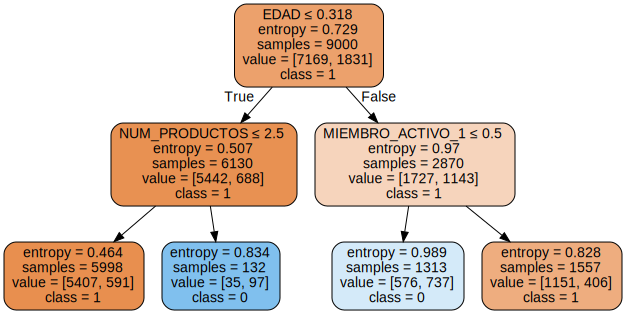

In [ ]:
import graphviz 
import collections
import pydotplus

dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names=new_raw_data.drop('ANULA', axis=1).columns,    
    class_names=new_raw_data['ANULA'].unique().astype(str),  
    filled=True, rounded=True,
    special_characters=True)
graph = graphviz.Source(dot_data)
graph

**Invertimos la escala que realizamos sobre las variables y volvemos a ejecutar el arbol de decision para tener una idea mas clara.**

X shape: (10000, 12)
y shape: (10000,)


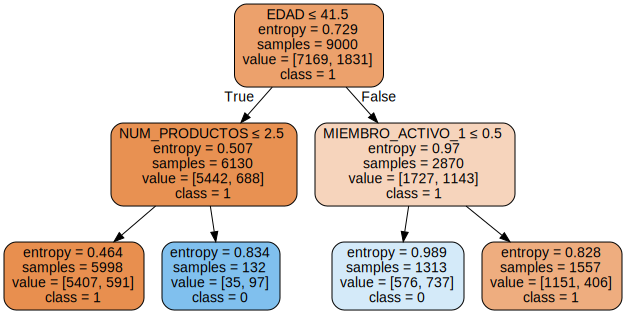

In [ ]:
new_raw_data = pd.get_dummies(raw_data2, columns = ['SEXO', 'POSEE_TC', 'MIEMBRO_ACTIVO'])

# Your code goes here
X = new_raw_data.drop('ANULA', axis=1).values # FILTRAR LOS ATRIBUTOS (VARIABLES INDEPENDIENTES)
y = new_raw_data['ANULA'].values # VECTOR OBJETIVO (VARIABLE DEPENDIENTE)
print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)

dt = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)
dt.fit(X_train, y_train)

import graphviz 
import collections
import pydotplus

dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names=new_raw_data.drop('ANULA', axis=1).columns,    
    class_names=new_raw_data['ANULA'].unique().astype(str),  
    filled=True, rounded=True,
    special_characters=True)
graph = graphviz.Source(dot_data)
graph

Observamos que de acuerdo a nuestro modelo el nodo raiz, o decisión principal corresponde a si el cliente tiene mas o menos de 41 años de edad.

Con la finalidad de evitar el sobreajuste, se limito el max_Depth hasta 2, lo cual restringira el numero de iteraciones. De no hacer esto, ***la division binaria recursiva*** continuaría hasta que las hojas sean puras o hasta que contengan menos muestras que min_samples_split (numero de muestras requeridas para dividir un nodo interno, es decir, el numero de datapoints necesarios para constituir una hoja). 

>A partir de los criterios antes descritos, el árbol de decisión decidirá internamente cual columna seleccionar para constituir el nodo raíz, los nodos subsecuentes y que criterios proporcionar como filtro.
Una vez que la raíz es seleccionada utilizando los criterios antes descritos, se establecen condiciones, todo este proceso constituye el modelo en cuestión. 


De esta forma, lo que quiere decir nuestro arbol, tomando en cuenta los nodos raiz, y rama, es que si la edad de nuestro cliente es < a 41 años el proceso de decision se movera a la izquierda, de no ser asi, será hacia la derecha,  y evaluará si posee menos de 2 productos; y asi sucesivamente hasta que se logre determinar si sera un cliente que anulará su cuenta o un cliente que se quedará.

In [ ]:
# Calcular la importancia del feature (rasgo, clasificacion)

for i, column in enumerate(new_raw_data.drop('ANULA', axis=1)):
    print('Importancia del rasgo {}:, {:.3f}'.format(column, dt.feature_importances_[i]))
    
    fi = pd.DataFrame({'Variable': [column], 'Puntuacion de la importancia del rasgo': [dt.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi,fi], ignore_index = True)
    except:
        final_fi = fi      


Importancia del rasgo CREDITO:, 0.000
Importancia del rasgo EDAD:, 0.622
Importancia del rasgo TENENCIA:, 0.000
Importancia del rasgo SALDO:, 0.000
Importancia del rasgo NUM_PRODUCTOS:, 0.196
Importancia del rasgo SALARIO_ESTIMADO:, 0.000
Importancia del rasgo SEXO_F:, 0.000
Importancia del rasgo SEXO_M:, 0.000
Importancia del rasgo POSEE_TC_0:, 0.000
Importancia del rasgo POSEE_TC_1:, 0.000
Importancia del rasgo MIEMBRO_ACTIVO_0:, 0.000
Importancia del rasgo MIEMBRO_ACTIVO_1:, 0.182


De esta forma tendremos las variables que contienen mas informacion y contibuyen en mayor medida a una mejor prediccion. En este caso, sabemos que las variables de edad, numero de productos y finalmente, si el cliente es un miembro activo de la entidad bancaria. Lo cual, efectivamente corresponde a los resultados arrojados por el arbol de decision. 

EVALUAMOS NUESTRO MODELO

Para ello evaluaremos las puntuaciones para los dataset de entrenamiento y de test.

In [ ]:
# PRECISION DEL ENTRENAMIENTO
print("La precision del entrenamiento es: ", dt.score(X_train, y_train))

# PRECISION DE LA PRUEBA
print("La precision de la prueba es: ", dt.score(X_test, y_test))

La precision del entrenamiento es:  0.8213333333333334
La precision de la prueba es:  0.822


Obervamos que la precision sobre el dataset de prueba es bastante alta, sin embargo, no es la unica metrica de evaluacion que deberiamos utilizar. Por ende, procederemos a utilizar una matriz de confusion para validar la efectividad de nuestro modelo. 
> La matriz de confusion es una medida de rendimiento para el problema de clasificación de aprendizaje automático donde la salida puede ser de dos o más clases. Es una tabla con 4 combinaciones diferentes de valores previstos y reales.

In [ ]:
# Confusion Matrix function

def plot_confusion_matrix(cm, classes=None, title='Matriz de confusión'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('VALOR REAL')
    plt.xlabel('VALOR PREDECIDO')


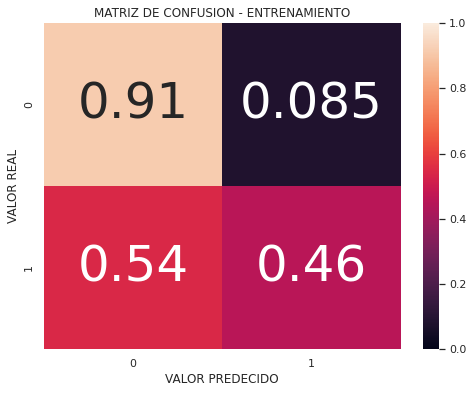

In [ ]:
y_pred = dt.predict(X_train)
# Plotting Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='MATRIZ DE CONFUSION - ENTRENAMIENTO')

La matriz contempla 4 clasificaciones:

>**Verdadero positivo:** (Cuadrante superior izquierdo). El valor real es positivo y  la prueba predijo tambien que 
era positivo. Es decir, el cliente anula su cuenta y la prueba lo predijo así.

>**Falso positivo:**(Cuadrante superior derecho). El valor real es negativo, y la prueba predijo  que el resultado es positivo. La persona no anula su cuenta, pero la prueba nos dice de manera incorrecta que si lo hace. Esto es lo que en estadística se conoce como error tipo I

>**Falso negativo:** (Cuadrante inferior izquierdo). El valor real es positivo, y la prueba predijo  que el resultado es negativo. La persona anula su cuenta, pero la prueba dice de manera incorrecta que no lo hace. Esto es lo que en estadística se conoce como error tipo II

>**Verdadero negativo:**(Cuadrante inferior derecho). El valor real  es negativo y la prueba predijo tambien que el resultado era negativo. O bien la persona no anula su cuenta y la prueba así lo  demuestra.




In [ ]:
y_pred = dt.predict(X_train)
y_pred
confusion_matrix(y_train, y_pred)

array([[6558,  611],
       [ 997,  834]])

> Como conclusión, la matriz de confusion nos dice que el modelo puede predecir con una precision del 92% a los clientes que NO anularan sus cuentas. No obstante, solo tenemos un 46% de certeza en la clasificación de los clientes que anularan sus cuentas, es decir, de nuestra variable objetivo.

**Con la finalidad de incrementar la precision de la estimación y conseguir generar una disminucion en el sobreajuste,adicional al prunning implementaremos arboles aleatorios**

7.- ARBOLES ALEATORIOS

> Sabemos que  los árboles de decisión son esos modelos de predicción formados por reglas binarias.Estos árboles de decisión forman los llamados modelos Random Forest Bootstrap o bosques aleatorios, combinados con bagging. De hecho, sus muestras son algo diferentes y la predicción se realiza de una nueva observación, que se ha añadido previamente a los árboles individuales de cada modelo.

Estos bosques aleatorios son muy empleados en bagging, debido a su rendimiento y rapidez. Ademas, como caracteristica principal, el bagging inicia con un modelo de alta complejidad que tiene alta varianza, y disminuye su varianza.

>Caracteristicas principales<br/>

>1) El bagging consiste en un proceso paralelo, es decir, ninguno de los arboles es dependiente de otro, cada arbol de decision que integra el bosque aleatorio es construido a partir de la data de forma independiente uno de otro.<br/>
2) Todos los árboles tienen el mismo peso en el modelo final. <br/>
3) Todos los modelos individuales son un arbol de decision en toda su definición.

*El bagging promedia modelos complejos para simplificarlos (combate la alta varianza)*


Nota:

Random forest es un clasificador que consta de muchos árboles de decisión y genera la clase que es la moda de los outputs de las clases de cada árbol individual.
Toma el promedio (ganancia de entropía/información) de muchos árboles de decisión mediante bagging.
Bagging es la abreviatura de "bootstrap aggregation", lo que significa que las muestras se eligen con reemplazo (bootstrap) y se combinan (aggregation) tomando su promedio.

En este caso el algoritmo ejecutará 100 arboles de decision distintos con humbrales de corte distintos y va a seleccionar la clase mas comun de esos 100 arboles de decision.
La forma de calcular la entropia o ganancia de informacion, es que promedia la entropia de esos 100 arboles de decision por clase. 
>La diferencia fundamental con la tecnica de bagging es que en los bosques aleatorios, solo un subconjunto de características se selecciona aleatoriamente del total y la mejor característica dividida del subconjunto se usa para dividir cada nodo en un árbol.

La precision del entrenamiento es:  0.9998888888888889
La precision de la prueba es:  0.854


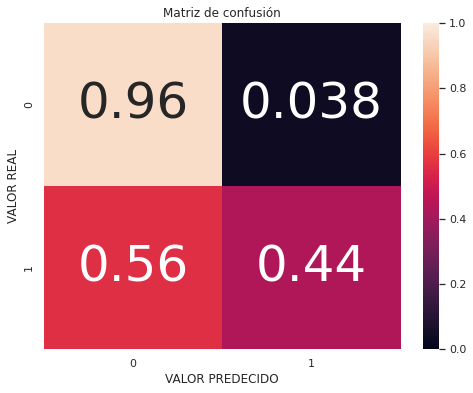

In [ ]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)
prediction_test = rf.predict(X=X_test)

print("La precision del entrenamiento es: ", rf.score(X_train, y_train))
print("La precision de la prueba es: ", rf.score(X_test, y_test))

# Matriz de confusion
cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)


Podemos observar que obtuvimos 96% de las no anulaciones correctas y 44% de las anulaciones correctas. En relacion al arbol de decisión, disminuyo un poco la precision pero tambien disminuyó el overfitting. Con la finalidad de mejorar nuestros resultados, ajustaremos los parametros.

Crearemos todas las posibles combinaciones posibles para visualizar cual combinacion nos permitira obtener el mejor resultado.

Precision de clasificación en el conjunto de prueba con max features = 1 y max_depth = None: 0.858
Precision de clasificación en el conjunto de prueba con max features = 1 y max_depth = 2: 0.794
Precision de clasificación en el conjunto de prueba con max features = 1 y max_depth = 3: 0.794
Precision de clasificación en el conjunto de prueba con max features = 1 y max_depth = 4: 0.800
Precision de clasificación en el conjunto de prueba con max features = 1 y max_depth = 5: 0.806
Precision de clasificación en el conjunto de prueba con max features = sqrt y max_depth = None: 0.855
Precision de clasificación en el conjunto de prueba con max features = sqrt y max_depth = 2: 0.806
Precision de clasificación en el conjunto de prueba con max features = sqrt y max_depth = 3: 0.812
Precision de clasificación en el conjunto de prueba con max features = sqrt y max_depth = 4: 0.856
Precision de clasificación en el conjunto de prueba con max features = sqrt y max_depth = 5: 0.867
Precision de clasif

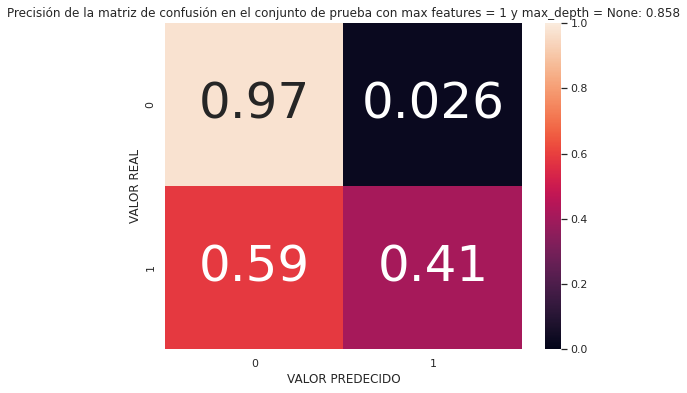

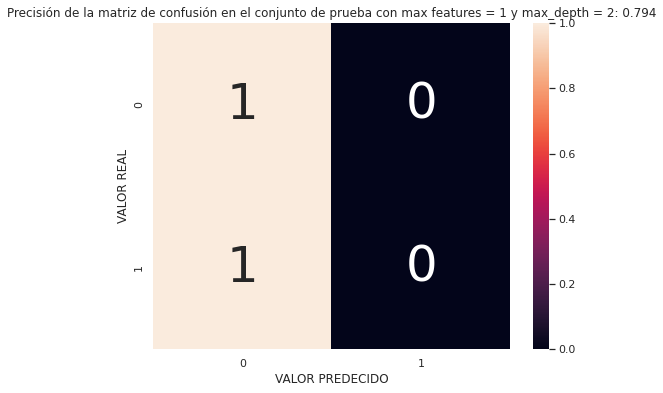

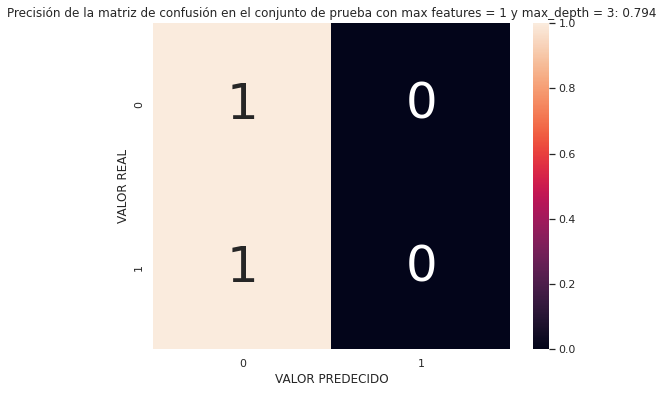

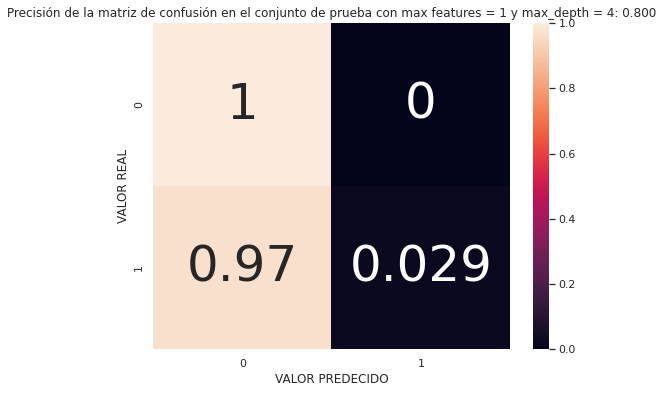

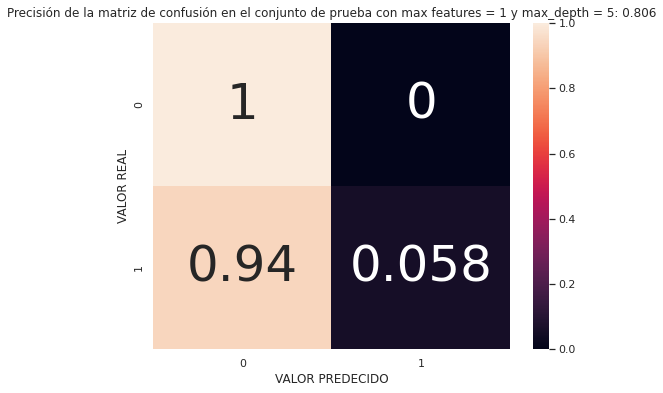

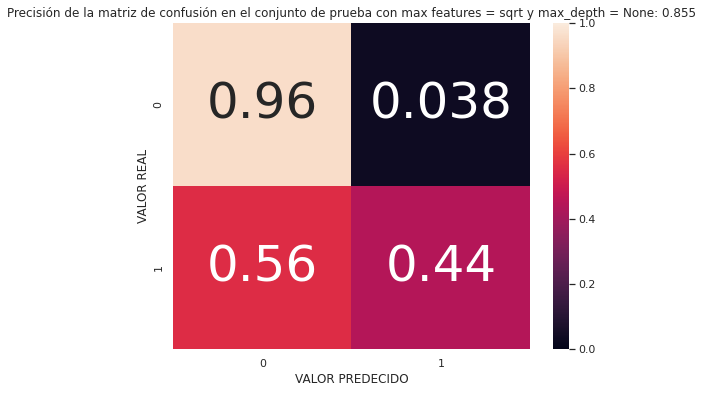

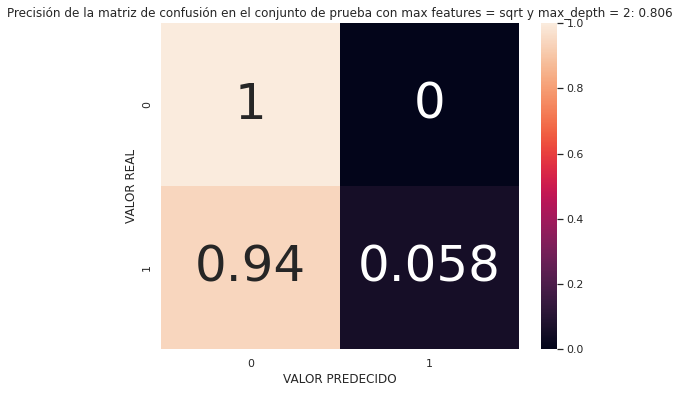

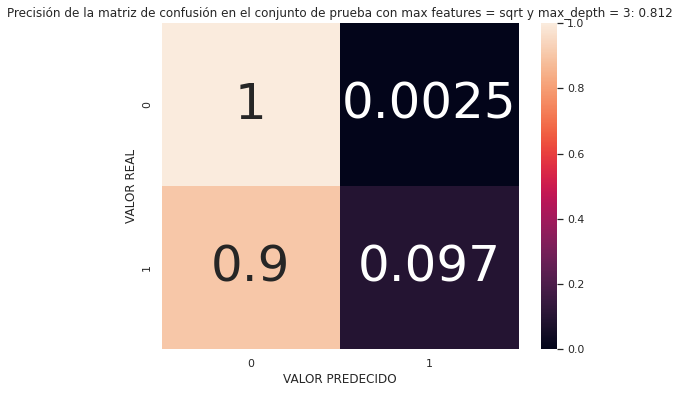

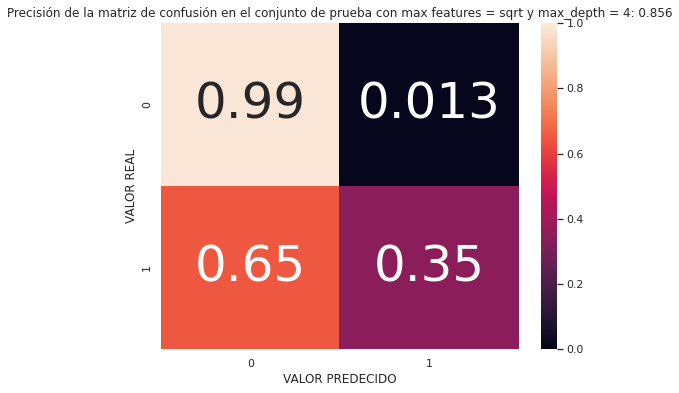

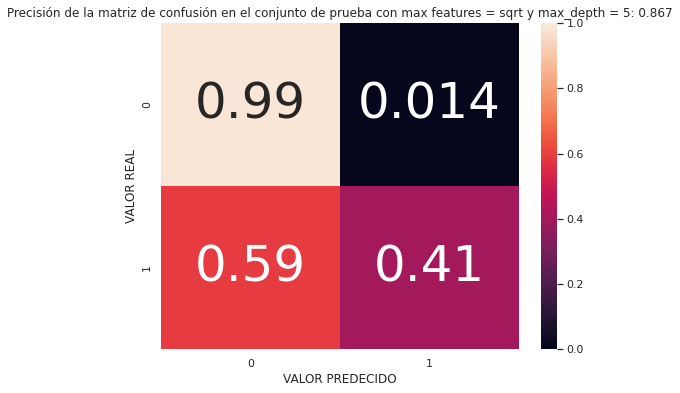

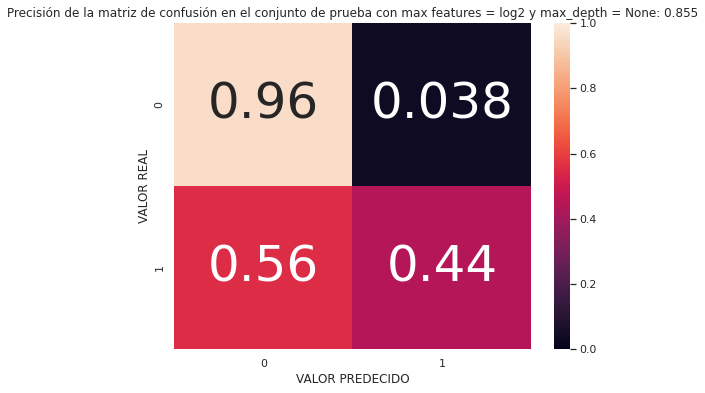

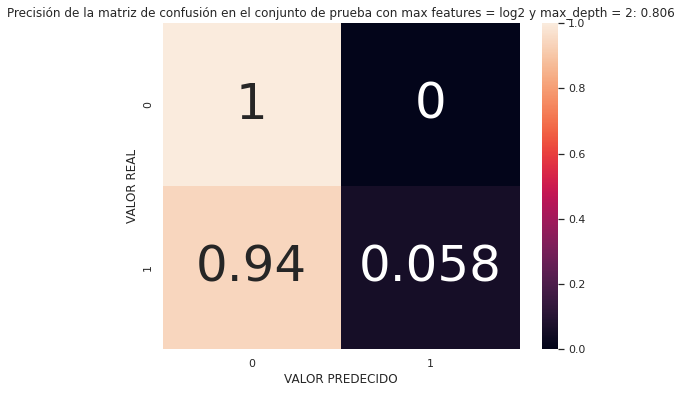

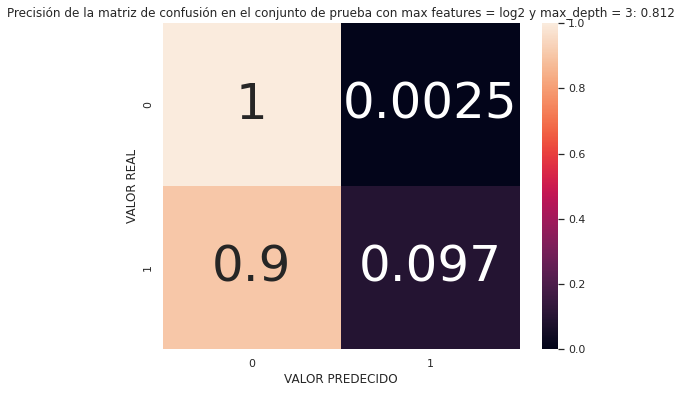

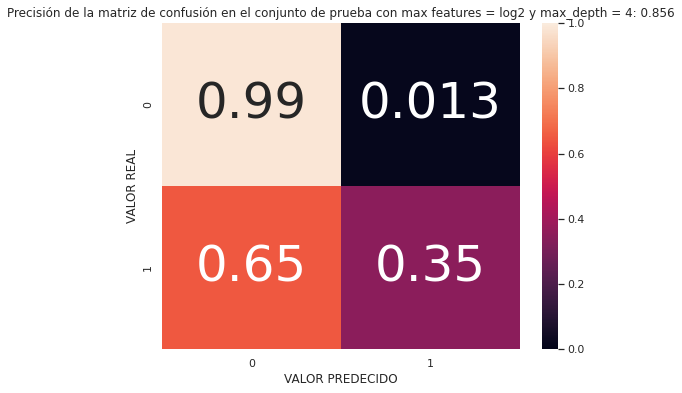

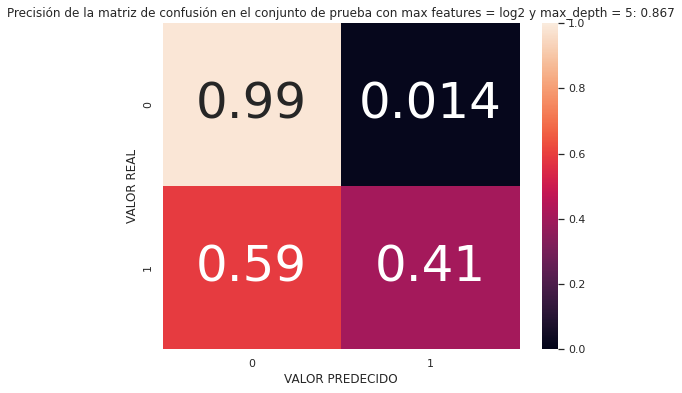

In [ ]:
# Tunning Random Forest

from itertools import product
n_estimators = 100
max_features = [1, 'sqrt', 'log2'] # caracteristicas a tomar en cuenta al buscar la mejor division
max_depths = [None, 2, 3, 4, 5] # con la finalidad de controlar el sobreajuste
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='entropy', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=1337)
    rf.fit(X_train, y_train)
    prediction_test = rf.predict(X=X_test)
    print('Precision de clasificación en el conjunto de prueba con max features = {} y max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Precisión de la matriz de confusión en el conjunto de prueba con max features = {} y max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
                      

De todas las posibles combinaciones nos interesa la que nos de el mayor porcentaje en el cuadrante inferior derecho pues es quien nos ayudara a predecir la cantidad de anulaciones. En este caso, tenemos 44% de precision en dos combinaciones de parametros. Con esas dos opciones podriamos ejecutar un nuevo arbol de decision y obtener nuestras respuestas. Sin embargo, no lo haremos; en su lugar ejecutaremos un proceso de boosting para intenta mejorar aun mas la precision de la prediccion.


> El bagging, también conocido como bootstrap aggregation, es el método de aprendizaje de conjunto que se usa comúnmente para reducir la varianza dentro de un conjunto de datos ruidoso. En el bagging, se selecciona una muestra aleatoria de datos en un conjunto de entrenamiento con reemplazo, lo que significa que los puntos de datos individuales se pueden elegir más de una vez. Después de generar varias muestras de datos, estos modelos débiles se entrenan de forma independiente y, según el tipo de tarea (regresión o clasificación, por ejemplo), el promedio o la mayoría de esas predicciones arrojan una estimación más precisa.

>*Como nota, el algoritmo de bosque aleatorio se considera una extensión del método de embolsado, que utiliza tanto el embolsado como la aleatoriedad de características para crear un bosque de árboles de decisión no correlacionado.BAGGING*





>Los métodos de bagging son métodos donde los algoritmos simples son usados en paralelo. El principal objetivo de los métodos en paralelo es el de aprovecharse de la independencia que hay entre los algoritmos simples, ya que el error se puede reducir bastante al promediar las salidas de los modelos simples

La diferencia fundamental del bagging con respecto a los bosques aleatorios es que este considera todas las características para dividir un nodo.


> El proceso de bagging (bootstrap + aggregating) utiliza un conjunto de modelos donde:

>Cada modelo utiliza un conjunto de datos de arranque (parte de arranque del bagging)<br/>
>Las predicciones de los modelos se agregan (la agregación forma parte del baggingo)<br/>
>Esto significa que en el bagging, puede usar cualquier modelo de su elección, no solo árboles.<br/>



¿Cómo funciona?

>**1) Bootstrapping:** el proceso de bagging aprovecha una técnica de muestreo de arranque para crear muestras diversas. Este método de remuestreo genera diferentes subconjuntos del conjunto de datos de entrenamiento seleccionando puntos de datos al azar y con reemplazo. Esto significa que cada vez que selecciona un punto de datos del conjunto de datos de entrenamiento, puede seleccionar la misma instancia varias veces. Como resultado, un valor/instancia repetido dos veces (o más) en una muestra.<br/>

>**2) Entrenamiento paralelo:** estas muestras de arranque se entrenan de forma independiente y en paralelo entre sí utilizando alumnos(learners) débiles (modelos simples que solo funcionan un poco mejor que el azar) o básicos.<br/>

>**3) Agregación:** finalmente, según la tarea (es decir, regresión o clasificación), se toma un promedio o la mayoría de las predicciones para calcular una estimación más precisa. En el caso de la regresión, se toma un promedio de todas las salidas pronosticadas por los clasificadores individuales; esto se conoce como voto suave. *Para problemas de clasificación, se acepta la clase con mayor mayoría de votos; esto se conoce como voto duro o voto mayoritario.*

In [ ]:
from sklearn. ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
bg = BaggingClassifier(DecisionTreeClassifier(), max_samples= 0.5, max_features = 1.0, n_estimators = 20)
bg.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.5,
                  n_estimators=20)

In [ ]:
bg.score(X_test,y_test)

0.84

In [ ]:
bg.score(X_train,y_train)

0.9408888888888889

*Podemos observar que los resultados obtenidos respecto a la evaluación de los modelos son similares entre el bagging y los bosques aleatorios.*

BOOSTING

Al hablar de boosting introducimos el termino **aprendizaje conjunto**, este da crédito a la idea de la "sabiduría de las multitudes", lo que sugiere que la toma de decisiones de un grupo más grande de personas suele ser mejor que la de un experto individual. De manera similar, el aprendizaje conjunto se refiere a un grupo (o conjunto) de aprendices básicos, o modelos, que trabajan colectivamente para lograr una mejor predicción final.<br/>

 Es posible que un solo modelo, también conocido como modelo básico o de aprendizaje débil, no funcione bien individualmente debido a la alta varianza o al alto sesgo. Sin embargo, cuando se agregan los alumnos débiles, pueden formar un alumno fuerte, ya que su combinación reduce el sesgo o la varianza, lo que produce un mejor rendimiento del modelo.
<br/>
> Por su parte, a diferencia del bagging (que destaca por su rapidez), el método boosting es una metodología general de aprendizaje lento. En este método se combinan una gran variedad de modelos que se obtienen de un método con poca predicción, con el objeto de dar lugar a un mejor predictor.

> De esta forma, aquí se emplean árboles de decisión construidos con poca profundidad, árboles pequeños y muy combinables. 

> Así mismo, en boosting lo que se hace es intentar arreglar los errores de predicción de los modelos anteriores. Árboles secuenciados que buscan mejorar la clasificación anterior.

>Un modelo aditivo, en el que se dan más importancia a las muestras mal clasificadas que a las que se encuentran bien en la 

Características:
> Es un proceso secuencial. Es decir, un modelo es dependiente del otro. <br/>
> Algunos modelos tendran mas o menos peso en la decisión del modelo final.<br/>
> Los arboles de decisión no constituyen arboles completos, son llamados "stumps", poseen solo un nodo raiz y dos nodos hoja.<br/>

In [ ]:
#Boosting - Ada Boost
from sklearn. ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
adb = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators = 5, learning_rate = 1)
adb.fit(X_train,y_train)
print("La efectividad sobre el conjundo de prueba es: ",adb.score(X_test,y_test))
print("La efectividad sobre el conjundo de entrenamiento es: ",adb.score(X_train,y_train))

La efectividad sobre el conjundo de prueba es:  0.777
La efectividad sobre el conjundo de entrenamiento es:  1.0


Notamos que incrementó la precisión sobre la data de entrenamiento, obteniendo así un mejor predictor, adicionalmente, disminuyó el sobreajuste.

Existen otros metodos de BOOSTING, ademas de ADABOOST:

8.- XGBOOST

Notes:

>Gradient Boosting es un algoritmo popular de boosting. En el gradient boosting, cada predictor corrige el error de su predecesor. A diferencia de Adaboost, los pesos de las instancias de entrenamiento no se modifican, sino que cada predictor se entrena utilizando los errores residuales del predecesor como etiquetas.<br/>

>En este algoritmo, los árboles de decisión se crean en forma secuencial. Los pesos juegan un papel importante en XGBoost. Se asignan pesos a todas las variables independientes que luego se introducen en el árbol de decisión que predice los resultados. El peso de las variables predichas incorrectamente por el árbol aumenta y estas variables luego se alimentan al segundo árbol de decisión. Estos clasificadores/predictores individuales luego se agrupan para dar un modelo fuerte y más preciso. Puede funcionar en problemas de regresión, clasificación, clasificación y predicción definida por el usuario.<br/>

>XGBoost es la abreviatura de "eXtreme Gradient Boost". Es un modelo de conjunto; Los modelos de conjunto combinan diferentes modelos de aprendizaje automático en uno. En lugar de agregar predicciones, los refuerzos convierten a los learners débiles en learners fuertes al enfocarse en dónde fallaron los modelos individuales. XGBoost entrena sobre los residuos. En lugar de agregar árboles, los árboles potenciados por gradientes aprenden de los errores durante cada ronda de potenciación

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade xgboost

**XGBoost matematicamente:**






In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost

classifier=xgboost.XGBClassifier(tree_method='gpu_hist')

params={
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth":[2,3,4,5,6,8,10,12,15],
    "min_child_weight":[1,3,5,7],
    "gamma":[0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7]}

clf =RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',cv=5,verbose=3)
# source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

# fitting it
clf.fit(X,y)

# best parameters
# clf.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=1;, score=0.857 total time=   1.3s
[CV 2/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=1;, score=0.844 total time=   0.6s
[CV 3/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=1;, score=0.846 total time=   0.6s
[CV 4/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=1;, score=0.851 total time=   0.6s
[CV 5/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=1;, score=0.839 total time=   0.6s
[CV 1/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=7;, score=0.856 total time=   0.6s
[CV 2/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=7;, score=0.846 total time=   0.6s
[CV 3/5] END colsample_by

RandomizedSearchCV(cv=5, estimator=XGBClassifier(tree_method='gpu_hist'),
                   n_iter=5,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [2, 3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [ ]:
clf.best_params_

{'min_child_weight': 7,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.1,
 'colsample_bytree': 0.5}

In [ ]:
# Obtenemos el modelo con los mejores parametros
clf.best_estimator_

XGBClassifier(colsample_bytree=0.5, gamma=0.1, max_depth=6, min_child_weight=7,
              tree_method='gpu_hist')

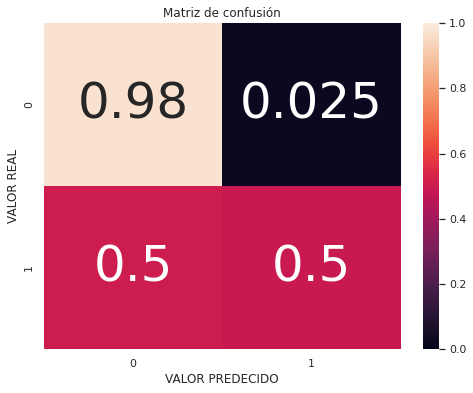

In [ ]:
# Ajustamos el modelo con los mejores parametros.

final_model = xgboost.XGBClassifier(colsample_bytree=0.5, gamma=0.1, max_depth=6, min_child_weight=7,
              tree_method='gpu_hist')
# Ajustamos
final_model.fit(X,y)

pred_xgboost = final_model.predict(X)

# Confusion Matrix
cm = confusion_matrix(y, pred_xgboost)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)

Hemos obtenido un modelo con 50% de precision.

**Probaremos nuestro modelo en nueva data que el modelo no conoce**

In [ ]:
# 9.1. Loading the new raw
url2 = ('https://raw.githubusercontent.com/prodriguezl1998/Riesgo2_proyecto1/main/data_nueva.csv')
unseen_data = pd.read_csv(url2)
print(unseen_data.shape)
unseen_data.head()

(3344, 12)


NUMERO_DE_FILA  CLIENTE_ID  CREDITO    SEXO  EDAD  TENENCIA      SALDO  \
0               1    15634638      619  Female    42         2       0.00   
1               2    15647347      608  Female    41         1   83807.86   
2               3    15619340      502  Female    42         8  159660.80   
3               4    15701390      699  Female    39         1       0.00   
4               5    15737924      850  Female    43         2  125510.82   

   NUM_DE_PRODUCTOS  POSEE_TC  MIEMBRO_ACTIVO  SALARIO_ESTIMADO  ANULA  
0                 1         1               1         101348.88      1  
1                 1         0               1         112542.58      0  
2                 3         1               0         113931.57      1  
3                 2         0               0          93826.63      0  
4                 1         1               1          79084.10      0

In [ ]:
#Aplicamos las mismas etapas de preprocesamiento

# Limiting the data
unseen_data2 = unseen_data[['CREDITO',
       'SEXO', 'EDAD', 'TENENCIA', 'SALDO', 'NUM_DE_PRODUCTOS', 'POSEE_TC',
       'MIEMBRO_ACTIVO', 'SALARIO_ESTIMADO']]

# dummy variables
unseen_data2 = pd.get_dummies(unseen_data2, columns = ['SEXO', 'POSEE_TC', 'MIEMBRO_ACTIVO'])

#scaling
scale_vars = ['CREDITO','SALARIO_ESTIMADO','SALDO','EDAD']
unseen_data2[scale_vars] = scaler.fit_transform(unseen_data2[scale_vars])


unseen_data2.head()

CREDITO      EDAD  TENENCIA     SALDO  NUM_DE_PRODUCTOS  SALARIO_ESTIMADO  \
0    0.538  0.342857         2  0.000000                 1          0.507077   
1    0.516  0.328571         1  0.334031                 1          0.563089   
2    0.304  0.342857         8  0.636357                 3          0.570039   
3    0.698  0.300000         1  0.000000                 2          0.469437   
4    1.000  0.357143         2  0.500246                 1          0.395667   

   SEXO_Female  SEXO_Male  POSEE_TC_0  POSEE_TC_1  MIEMBRO_ACTIVO_0  \
0            1          0           0           1                 0   
1            1          0           1           0                 0   
2            1          0           0           1                 1   
3            1          0           1           0                 1   
4            1          0           0           1                 0   

   MIEMBRO_ACTIVO_1  
0                 1  
1                 1  
2                 0  
3                 0  
4                 1

In [ ]:
#Hacemos predicciones

pred_xgboost = final_model.predict(unseen_data2.values)
pred_prob_xgboost = final_model.predict_proba(unseen_data2.values)

pred_xgboost

array([0, 0, 1, ..., 0, 0, 0])

Se genera un vector binario, en el cual los 0 seran no anulaciones y los 1 seran anulaciones.

In [ ]:
# probabilities
pred_prob_xgboost

array([[0.824034, 0.175966],
       [0.836626, 0.163374],
       [0.297373, 0.702627],
       ...,
       [0.817602, 0.182398],
       [0.974329, 0.025671],
       [0.765875, 0.234125]], dtype=float32)

Las probabilidades del lado izquierdo seran las probabilidades de no ser anulaciones y las del lado derecho seran las de ser anulaciones. De esta forma, las primers dos personas no son anulaciones y la trcera si, pues tiene 98% de prob de ser una anulacion.

In [ ]:
# FUNCION PARA SELCCIONAR LA SEGUNDA COLUMNA 
def column(matrix, i):
    return [row[i] for row in matrix]

column(pred_prob_xgboost, 1)

Si es un 0 el vector te devolvera la primera columna y si es un 1, devolverá la segunda.

In [ ]:
# 9.4. UNIENDO LA DATA CON LAS PREDICCIONES

output = unseen_data.copy()
output['Predictions - Anulacion o no'] = pred_xgboost
output['Predictions - Probabilidad de anular'] = column(pred_prob_xgboost, 1)
output['Predictions - Anulacion o no Desc'] = 'Empty'
output['Predictions - Anulacion o no Desc'][output['Predictions - Anulacion o no'] == 0] = 'Retencion'
output['Predictions - Anulacion o no Desc'][output['Predictions - Anulacion o no'] == 1] = 'Anulacion'
output.head()

NUMERO_DE_FILA  CLIENTE_ID  CREDITO    SEXO  EDAD  TENENCIA      SALDO  \
0               1    15634638      619  Female    42         2       0.00   
1               2    15647347      608  Female    41         1   83807.86   
2               3    15619340      502  Female    42         8  159660.80   
3               4    15701390      699  Female    39         1       0.00   
4               5    15737924      850  Female    43         2  125510.82   

   NUM_DE_PRODUCTOS  POSEE_TC  MIEMBRO_ACTIVO  SALARIO_ESTIMADO  ANULA  \
0                 1         1               1         101348.88      1   
1                 1         0               1         112542.58      0   
2                 3         1               0         113931.57      1   
3                 2         0               0          93826.63      0   
4                 1         1               1          79084.10      0   

   Predictions - Anulacion o no  Predictions - Probabilidad de anular  \
0                             0                              0.175966   
1                             0                              0.163374   
2                             1                              0.702627   
3                             0                              0.061901   
4                             0                              0.175966   

  Predictions - Anulacion o no Desc  
0                         Retencion  
1                         Retencion  
2                         Anulacion  
3                         Retencion  
4                         Retencion

**Otra categoría dentro de los arboles de decisión, son los arboles de regresion**<br/>


> Los arboles de regresión observan las características de un objeto y entrena un modelo en la estructura de un árbol para predecir datos en el futuro para producir resultados continuos significativos. Esto significa que la salida/resultado no es discreto, es decir, no está representado simplemente por un conjunto discreto y conocido de números o valores.



En los modelos de regresión se intenta predecir el valor de una variable en función de otras variables que son independientes entre sí. En nuestro caso, trataremos de predecir el consumo POS de determinada entidad bancaria basados en el tipo de cambio oficial del BCV.

In [ ]:
#### PRUEBA PARA REGRESION####
#predecir el consumo pos acumulado (5 dias) basados en el tipo de cambio bcv.

url = 'https://raw.githubusercontent.com/prodriguezl1998/Riesgo2_proyecto1/main/consumo_pos_arbol_regresion.csv' 
data = pd.read_csv(url)
X = data.iloc[:, 1].values.reshape(-1, 1)  # iloc converts in a array and reshape reshapes it # values converts it into a numpy array
y = data.iloc[:, 0].values.reshape(-1, 1) 

#raw_data.corr(method='pearson') # DE AQUI SACO LAS VARIABLES
#X = raw_data["EDAD"].values.reshape(-1,1)
#y = raw_data["CREDITO"].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)

DtReg = DecisionTreeRegressor(random_state = 0)
DtReg.fit(X_train,y_train)
y_predict_dtr = DtReg.predict((X_test))
from sklearn import metrics
r_square = metrics.r2_score(y_test,y_predict_dtr)
print('R cuadrado asociado al arbol de regresion es:', r_square)

R cuadrado asociado al arbol de regresion es: 0.9282199014826356


Notamos que el ajuste R2 es de 0.92, cercano a 1 lo cual indica precisión en la predicción. 

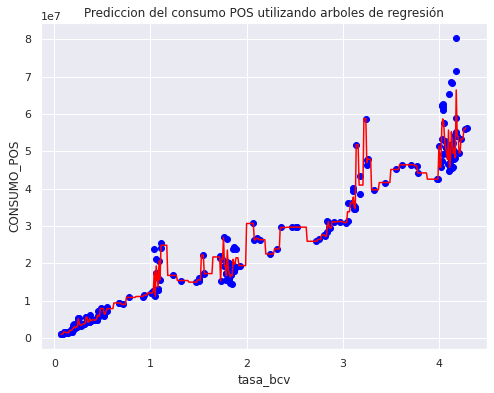

<Figure size 72x72 with 0 Axes>

predicted y: 29717990


In [ ]:
X_val = np.arange(min(X_train), max(X_train),0.01)
X_val = X_val.reshape((len(X_val),1))
plt.scatter(X_train,y_train,color = 'blue')
plt.plot(X_val,DtReg.predict(X_val),color = 'red')
plt.title('Prediccion del consumo POS utilizando arboles de regresión')
plt.xlabel('tasa_bcv')
plt.ylabel('CONSUMO_POS')
plt.figure(figsize = (1,1))
plt.show()


En la construccion de los arboles de decision se crean rectangulos en la data basados en distinto humbrales de corte, cada rectangulo contiene observaciones y se toman los promedios de esas observciones para predecir el valor de la variable objetivo.<br/>
>Si observamos con detenimiento visualizaremos **lineas verticales** en la grafica, estas lineas representan la no continuidad de la grafica, a diferencia de la regresión lineal donde tenemos una recta de regresion, es decir, puntos continuos. Podemos observar tambien que hay **lineas horizontales** entre dos lineas verticales, esos puntos representan intervalos. El algortmo de arboles de regresion toma un promedio de todas las observaciones en ese intervalo con la finalidad de predecir el valor de la variable objetivo.



> Tomando en cuenta lo antes descrito, si intentamos predecir por ejemplo, el consumo POS para valores entre 2,3 y 2,5 aproximadamente, debería arrojar un valor cercano a los 30mill.



In [ ]:
pred = DtReg.predict([[2.5]])
print("predicted y: %d"% pred)

predicted y: 29717990


Efectivamente, se cumple lo antes descrito.<br/>

**Finalmente, visualizamos nuestro arbol de regresión.**

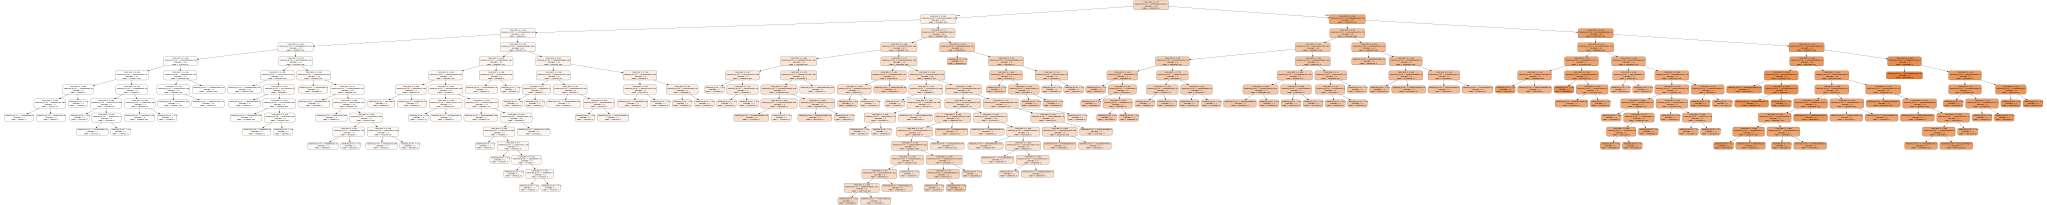

In [ ]:
from sklearn.tree import export_graphviz 
# export the decision tree to a tree.dot file
# for visualizing the plot easily anywhere


import graphviz 
import collections
import pydotplus

dot_data = tree.export_graphviz(DtReg, out_file=None, 
    feature_names=data.drop('CONSUMO_POS_ACUM_5', axis=1).columns,    
    class_names=data['tasa_BCV'].unique().astype(str),  
    filled=True, rounded=True,
    special_characters=True)
graph = graphviz.Source(dot_data)
graph